# Tensor or field surrogates

In order to fit tensors or fields, i.e., a multi-output or multi-target machine learning regression, we can utilize the multiple PCE regression wrapper which is part of tesuract's toolbox. 

In a nutshell, tesuract uses sklearn's Pipeline machinery to (1) transform the target into a lower-dimensional latent space, typically through PCA, (2) then creates a separately tuned surrogate for each of the latent space dimensions, and then (3) projects the solution back into the physical space. 

This is summarized in the image below.

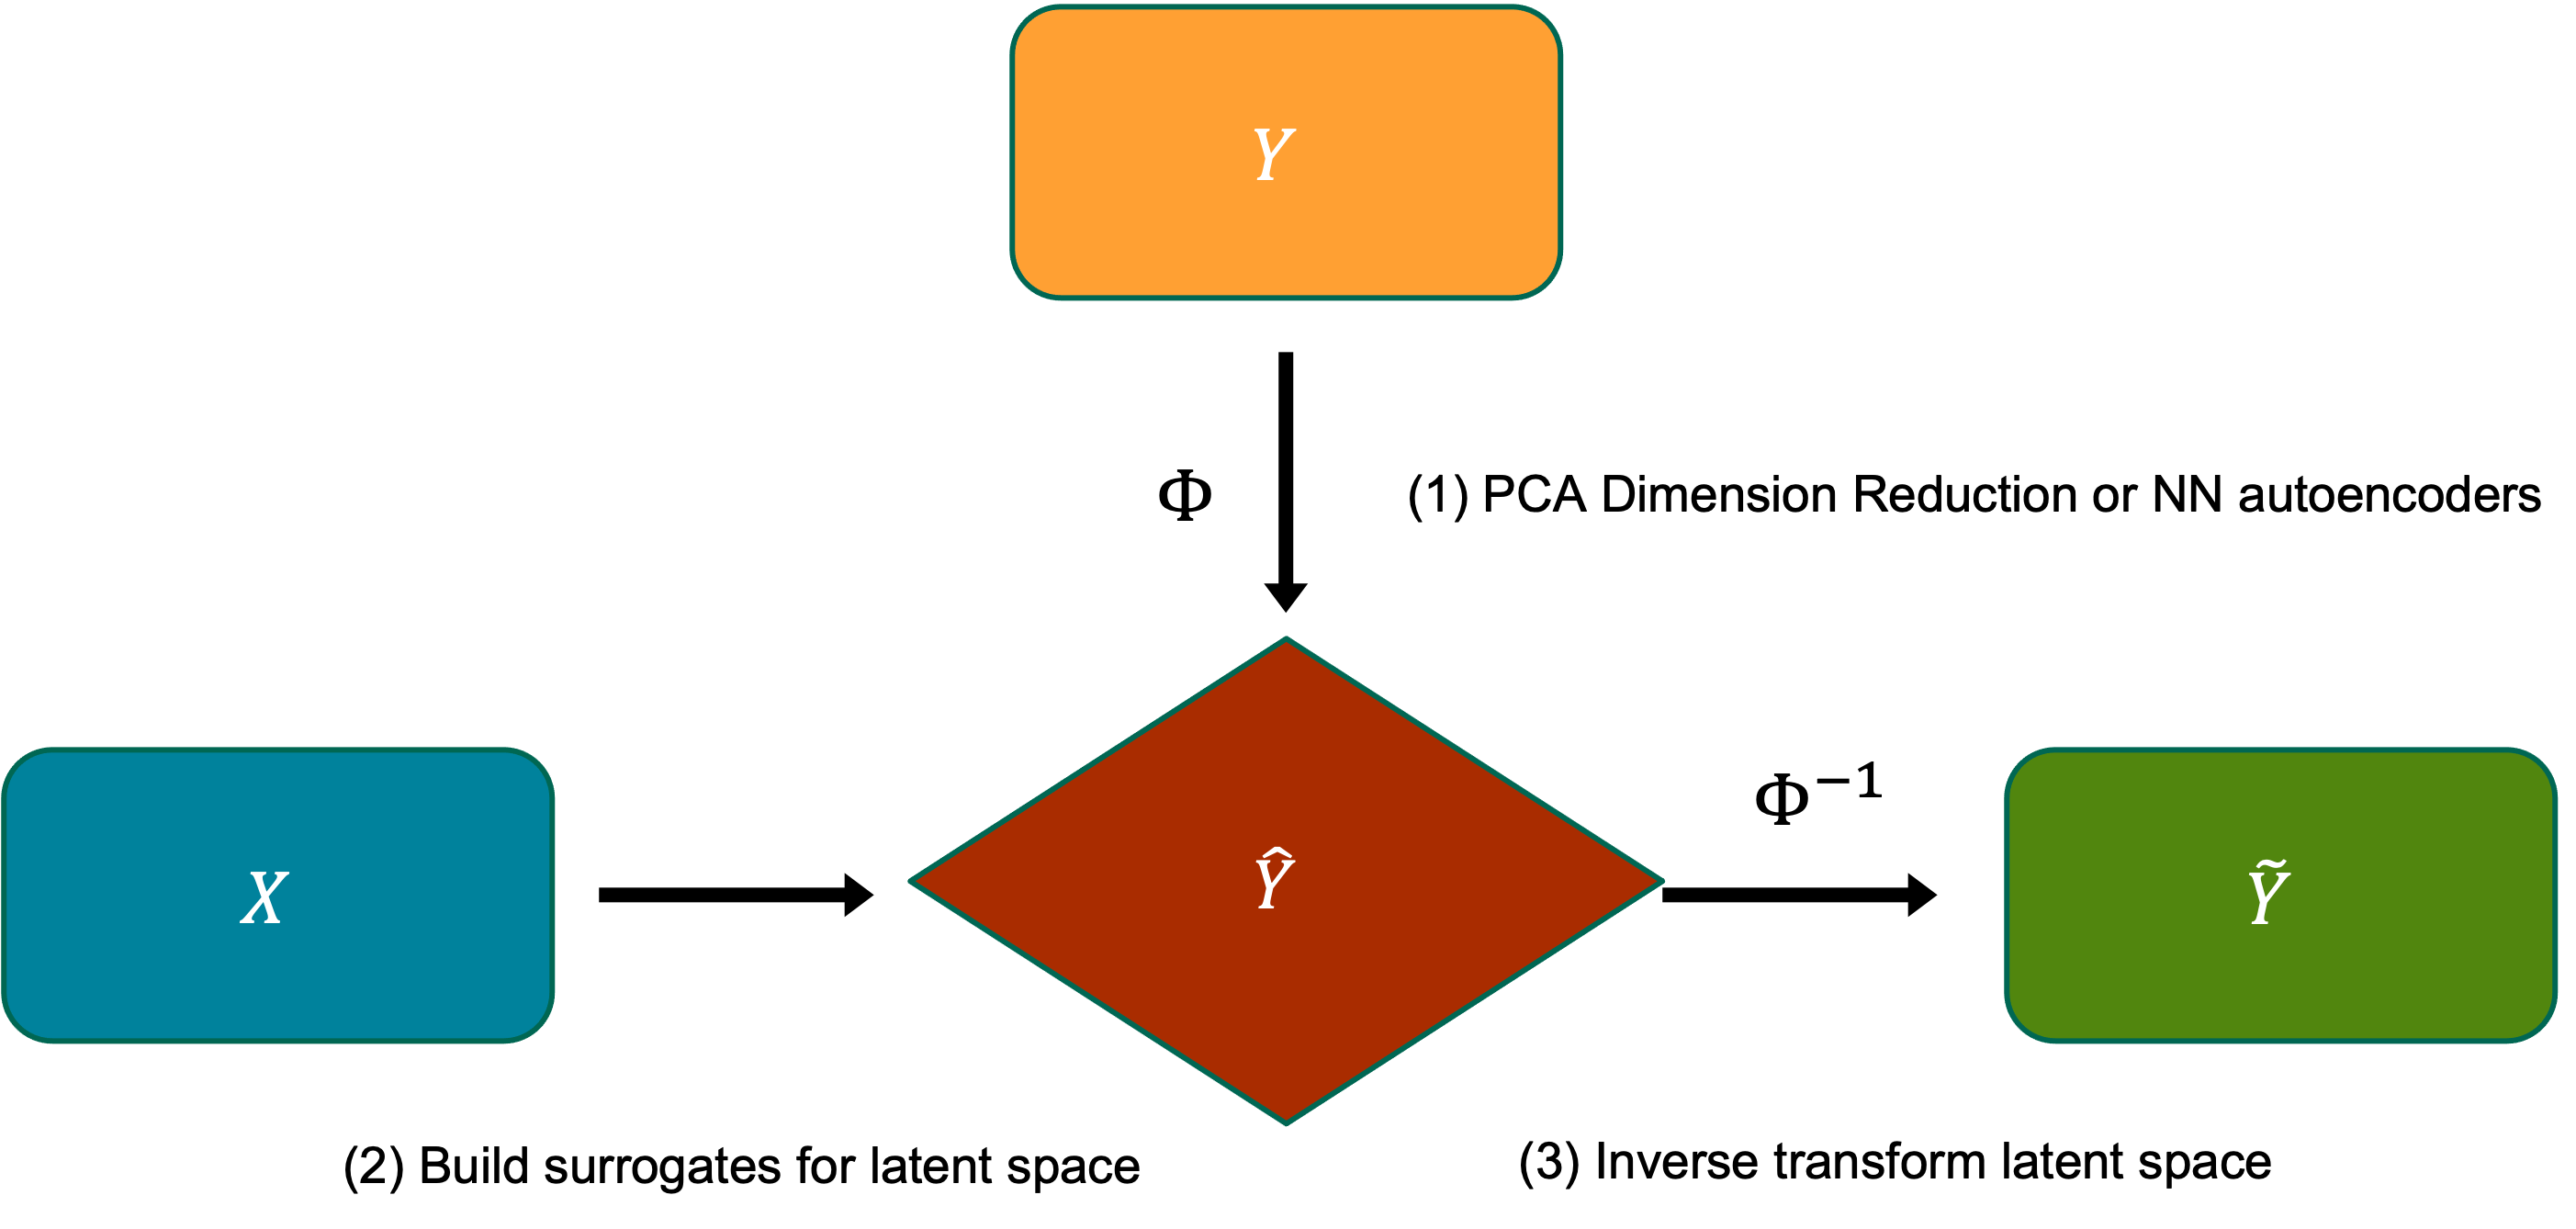

Let's see how to perform this fit using the tools in tesuract. First, we will need to import a relevant data set which we have conveniently added to the data folder in the tests directory. 

In [1]:
import numpy as np
import tesuract
%matplotlib inline

# load the relevant data set
loaddir = "../../../tesuract/tests/data/"
X = np.loadtxt("rom_test_X.txt")
Y = np.loadtxt("rom_test_Y.txt")

# print out the shapes of the input and output
X.shape, Y.shape

((100, 2), (100, 288))

As one can see, the input is a two-dimensional feature space, but the output is a 288-dimensional field or tensor. 

Now, we can fit each and every one of the 288 outputs with a ML regressor, but if we were to utilize hyper-parameter tuning (and we should if we can), this would be extremely expensive and cumbersome.

Instead, we introduce a target transform which takes the output and projects it onto a lower-dimensional latent space, after which, we do all our fitting. 

## PCA target transform

Let's define a simple target transform using sklearn's PCA with say 4 components. In general, we can make the choice of this automatic, but for now, let's define the number of components or latent space dimensions. All we need to do is call sklearn's PCA and feed it in some parameter options as a dictionary. 

In [3]:
from sklearn.decomposition import PCA

Now, all we do is call `tesuract.MRegressionWrapperCV` which is almost identical to `tesuract.RegressionWrapperCV` except that we can feed it in a target transform (Note that any sklearn transform will work here, even a simple scalar transform, although that doesn't save you in terms of computational cost). 

In [4]:
# define pce grid again
pce_grid = {
    'order': list(range(1,8)),
    'mindex_type': ['total_order'],
    'fit_type': ['ElasticNetCV'],
    }

mpce = tesuract.MRegressionWrapperCV(
    regressor='pce',
    reg_params=pce_grid,
    target_transform=PCA,
    target_transform_params={'n_components':4})

And that's it! Now we can feed it in our multi-target training data pair (X,Y). This will take a little bit of time since we are fitting each of the 8 components with a PCE. While this is done in serial, each hyper-parameter search is done in parallel. 

In [5]:
mpce.fit(X,Y)

on 0: Fitting 5 folds for each of 7 candidates, totalling 35 fits
on 1: Fitting 5 folds for each of 7 candidates, totalling 35 fits
on 2: Fitting 5 folds for each of 7 candidates, totalling 35 fits
on 3: Fitting 5 folds for each of 7 candidates, totalling 35 fits
|████████████████████████████████████████| 4/4 [100%] in 5.5s (0.72/s)


MRegressionWrapperCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                     reg_params={'fit_type': ['ElasticNetCV'],
                                 'mindex_type': ['total_order'],
                                 'order': [1, 2, 3, 4, 5, 6, 7]},
                     target_transform=<class 'sklearn.decomposition._pca.PCA'>,
                     target_transform_params={'n_components': 4})

Once this is complete, we can view the best estimators for each of the components, along with their respective scores and parameters. 

In [7]:
# show the parameters of the best fit PCEs for the four components
mpce.best_params_

[{'fit_type': 'ElasticNetCV', 'mindex_type': 'total_order', 'order': 6},
 {'fit_type': 'ElasticNetCV', 'mindex_type': 'total_order', 'order': 5},
 {'fit_type': 'ElasticNetCV', 'mindex_type': 'total_order', 'order': 1},
 {'fit_type': 'ElasticNetCV', 'mindex_type': 'total_order', 'order': 3}]

In [12]:
# extract the best estimators for each componentbest_estimators = mpce.best_estimators_

To make predictions using the best estimators, one can simply use the predict method, which is automatically use the best estimators to make the prediction. 

In [13]:
mpce.predict(X)

array([[-5.9192281 , -6.29485307, -6.29485307, ...,  0.        ,
         0.        ,  0.        ],
       [-5.84729987, -6.19757176, -6.19757176, ...,  0.        ,
         0.        ,  0.        ],
       [-5.95122359, -6.34418361, -6.34418361, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-5.89743814, -6.26569268, -6.26569268, ...,  0.        ,
         0.        ,  0.        ],
       [-5.80345682, -6.13921674, -6.13921674, ...,  0.        ,
         0.        ,  0.        ],
       [-5.94735135, -6.39569148, -6.39569148, ...,  0.        ,
         0.        ,  0.        ]])

Note that one can define a whole slew of options in the PCE parameter grid. For example, when using LassoCV, it might be necessary to increase the maximum iteration or the tolerance. In this case, one can easily modify the grid to look like the following. 

In [24]:
pca = PCA(n_components=4)
print(pca)

type(pca)

isinstance(pca,PCA)

PCA(n_components=4)


True

In [20]:
n_components = 4
reg_custom_list = ['pce' for i in range(n_components)]
reg_param_list = mpce.best_params_

clone = tesuract.MRegressionWrapperCV(
    regressor=reg_custom_list,
    reg_params=reg_param_list,
    custom_params = True,
    target_transform=PCA(n_components=4),
    target_transform_params={},
    n_jobs=-1,verbose=0)

clone.fit(X,Y)

TypeError: 'PCA' object is not callable

/Users/kchowdh/.pyenv/versions/3.8.10/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2841.7118276228575, tolerance: 1801.892091541685
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kchowdh/.pyenv/versions/3.8.10/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2490.611798921702, tolerance: 1801.892091541685
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kchowdh/.pyenv/versions/3.8.10/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6452.421538161299, tolerance: 2290.6717201761235
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kchowdh/.pyenv/v

## Modifying the parameter grid

In [14]:
pce_grid = [
    {'order': list(range(1,10)),
    'mindex_type': ['total_order','hyperbolic'],
    'fit_type': ['linear','ElasticNetCV'],
    'fit_params': [{'alphas':np.logspace(-8,4,20),'max_iter':100000,'tol':5e-2}]
    },
    {'order': list(range(1,10)),
    'mindex_type': ['total_order','hyperbolic'],
    'fit_type': ['LassoCV'],
    'fit_params': [{'alphas':np.logspace(-8,3,15),'max_iter':500000,'tol':1.5e-1}]}
     ]

mpce2 = tesuract.MRegressionWrapperCV(
    regressor=['pce'],
    reg_params=[pce_grid],
    target_transform=PCA,
    target_transform_params={'n_components':4})

mpce2.fit(X,Y)

on 0: Fitting 5 folds for each of 54 candidates, totalling 270 fits
on 1: Fitting 5 folds for each of 54 candidates, totalling 270 fits
on 2: Fitting 5 folds for each of 54 candidates, totalling 270 fits
on 3: Fitting 5 folds for each of 54 candidates, totalling 270 fits
|████████████████████████████████████████| 4/4 [100%] in 56.2s (0.07/s)


MRegressionWrapperCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                     reg_params=[[{'fit_params': [{'alphas': array([1.00000000e-08, 4.28133240e-08, 1.83298071e-07, 7.84759970e-07,
       3.35981829e-06, 1.43844989e-05, 6.15848211e-05, 2.63665090e-04,
       1.12883789e-03, 4.83293024e-03, 2.06913808e-02, 8.85866790e-02,
       3.79269019e-01, 1.62377674e+00, 6.95192796e+00, 2.9763...
       1.93069773e-02, 1.17876863e-01, 7.19685673e-01, 4.39397056e+00,
       2.68269580e+01, 1.63789371e+02, 1.00000000e+03]),
                                                   'max_iter': 500000,
                                                   'tol': 0.15}],
                                   'fit_type': ['LassoCV'],
                                   'mindex_type': ['total_order', 'hyperbolic'],
                                   'order': [1, 2, 3, 4, 5, 6, 7, 8, 9]}]],
                     regressor=['pce'],
                     target_transform=<class 'sklearn.decompos

In [15]:
mpce.best_params_

[{'fit_type': 'ElasticNetCV', 'mindex_type': 'total_order', 'order': 6},
 {'fit_type': 'ElasticNetCV', 'mindex_type': 'total_order', 'order': 5},
 {'fit_type': 'ElasticNetCV', 'mindex_type': 'total_order', 'order': 1},
 {'fit_type': 'ElasticNetCV', 'mindex_type': 'total_order', 'order': 3}]